# Test models of RNN-Registration project

In [12]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
from utils import losses
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Config

In [125]:
class Args():
    def __init__(self):  
        self.SERVER = 166
        self.model = 'p3rnn'
        self.all_patients = False
        self.one_patient = 3
        if not self.one_patient and not self.all_patients:
            self.p_from = 0
            self.p_to = 5
        self.use_rnn = True
        self.checkpoint = '4000'
        self.batch_size = 1
        self.multi_windows = True
        self.use_filtered_dataset = True
        
        # if rnn
        self.rnn_hidden_dim = 8
        self.rnn_mid_flow_size = 4

        # if multi windows
        self.window = 4
        self.step = 2
        
        if self.SERVER == 168:
            self.data_base = '/home/khalili/kian-data/'
            self.models_base = '/home/khalili/kian-data/saved-models/'
        elif self.SERVER == 166:
            self.data_base = '/HDD/vxm-models/structured-data/'
            self.models_base = '/HDD/kian/saved-models/bDir/'
        
args = Args()

### Reading data

In [110]:
with open(f'{args.data_base}{"filtered" if args.use_filtered_dataset else "unfiltered"}_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)

with open(f'{args.data_base}{"filtered" if args.use_filtered_dataset else "unfiltered"}_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)

images, labels = [], []
for i, img in pre_images.items():
    images.append(torch.from_numpy(img))
    
for i, lb in pre_labels.items():
    labels.append(torch.from_numpy(lb))    

# Normalize        
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()
for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

### Dataloader

In [111]:
class Dataset_(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.image_size = images[0].shape[1:]
        self.ndims = len(self.image_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        outputs = [self.images[index], self.labels[index]]
        return tuple(outputs)
    

def get_dataloader(images, labels, batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = Dataset_(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=workers)
    return dataloader


if args.all_patients:
    dataloader = get_dataloader(images, labels, args.batch_size)
    print(f'___dataloader filled with all data___')
elif args.one_patient:
    dataloader = get_dataloader([images[args.one_patient]], [labels[args.one_patient]], args.batch_size)
    print(f'___dataloader filled with patient number {args.one_patient}___')
elif args.p_to:
    dataloader = get_dataloader(images[args.p_from:args.p_to], labels[args.p_from:args.p_to], args.batch_size)
    print(f"____dataloader filled with patients range: {args.p_from}: {args.p_to}____")
else:
    raise Exception(f"Ambiguity in Data set: all_patients: {args.all_patients}, one_patient: {args.one_patient}"
                    f" p_from: {args.p_from}, p_to: {args.p_to}")

### Unet_ConvLSTM model

In [112]:
import torch.nn as nn
from models.unet_convlstm import Unet_ConvLSTM
from models.unet import Unet
from models2.convlstm import ConvLSTM
from utils.spatial_transform import SpatialTransformer


class Unet_ConvLSTM(nn.Module):
    def __init__(self, image_size, args):
        super(Unet_ConvLSTM, self).__init__()
        self.image_size = image_size
        self.ndims = len(image_size)
        Conv = getattr(nn, 'Conv%dd' % self.ndims)

        # Unet
        enc_nf = [16, 32, 32, 32]
        dec_nf = [32, 32, 32, 32, 32, 16, 16]
        self.unet = Unet(inshape=image_size, infeats=2, nb_features=[enc_nf, dec_nf])
        self.unet_flow = Conv(in_channels=self.unet.final_nf, out_channels=2, kernel_size=3, padding=1)

        # RNN
        self.hidden_dim = args.rnn_hidden_dim
        self.flow = Conv(in_channels=self.hidden_dim, out_channels=args.rnn_mid_flow_size, kernel_size=3, padding=1)
        self.flow_2 = Conv(in_channels=args.rnn_mid_flow_size, out_channels=2, kernel_size=3, padding=1)
        self.rnn = ConvLSTM(img_size=image_size, input_dim=self.unet.final_nf, hidden_dim=self.hidden_dim,
                            kernel_size=(3, 3), bidirectional=False, return_sequence=True, batch_first=False)

        self.spatial_transformer = SpatialTransformer(size=image_size)

    def forward(self, images, labels=None, use_rnn=True):

        # shape of imgs/lbs: (seq_size, bs, 1, W, H)
        # shape of unet_out: (seq_size - 1, bs, 2, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        # shape of moved_images = (seq_size - 1, bs, 1, W, H)

        # Forward: registering slice i to i + 1
        forward_sources, forward_targets = images[:-1], images[1:]
        src_trg_zip = zip(forward_sources, forward_targets)
        if use_rnn:
            forward_unet_out = torch.cat([self.unet(torch.cat([src, trg], dim=1)).unsqueeze(0)
                                          for src, trg in src_trg_zip], dim=0)
            rnn_out, last_states, _ = self.rnn(forward_unet_out)
            x = self.flow(rnn_out[0].squeeze(0))
            x = torch.nn.functional.leaky_relu(x)
            forward_flows = self.flow_2(x).unsqueeze(1)
        else:
            forward_flows = torch.cat([self.unet_flow(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0)
                                       for src, trg in src_trg_zip], dim=0)

        forward_moved_images = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0)
             for src, flow in zip(forward_sources, forward_flows[:])], dim=0)

        if labels is not None:
            forward_lbs_sources = labels[:-1]
            forward_moved_labels = torch.cat(
                [self.spatial_transformer(src, flow).unsqueeze(0)
                 for src, flow in zip(forward_lbs_sources, forward_flows[:])], dim=0)

        # Backward: registering slice i to i - 1
        backward_sources, backward_targets = images[1:], images[:-1]
        src_trg_zip = zip(backward_sources, backward_targets)
        if use_rnn:
            backward_unet_out = torch.cat([self.unet(torch.cat([src, trg], dim=1)).unsqueeze(0)
                                           for src, trg in src_trg_zip], dim=0)
            rnn_out, last_states, _ = self.rnn(backward_unet_out)
            x = self.flow(rnn_out[0].squeeze(0))
            x = torch.nn.functional.leaky_relu(x)
            backward_flows = self.flow_2(x).unsqueeze(1)
        else:
            backward_flows = torch.cat([self.unet_flow(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0)
                                        for src, trg in src_trg_zip], dim=0)

        backward_moved_images = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0)
             for src, flow in zip(backward_sources, backward_flows[:])], dim=0)

        if labels is not None:
            backward_lbs_sources = labels[1:]
            backward_moved_labels = torch.cat(
                [self.spatial_transformer(src, flow).unsqueeze(0)
                 for src, flow in zip(backward_lbs_sources, backward_flows[:])], dim=0)
            return forward_moved_images, forward_moved_labels, backward_moved_images, backward_moved_labels
        else:
            return forward_moved_images, backward_moved_images

In [113]:
model = Unet_ConvLSTM(dataloader.dataset.image_size, args)
model.to('cuda')
model.eval()

(3, 3)


Unet_ConvLSTM(
  (unet): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3)

### Loading model

In [116]:
PATH = f'{args.models_base}{args.model}/{args.checkpoint}.pt'
checkpoint = torch.load(PATH)
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except:
    model.load_state_dict(checkpoint)

In [117]:
def dice(y_true, y_pred):
    zero = torch.zeros_like(y_true)
    one = torch.ones_like(y_true)
    y_true = torch.where(y_true > 0, one, zero)
    y_pred = torch.where(y_pred > 0, one, zero)

    dices = []
    for i in range(y_true.shape[0]):
        a, b = y_true[i], y_pred[i]
        top = 2 * np.multiply(a, b).sum()
        bottom = a.sum() + b.sum()
        dices.append(top / bottom)
    return dices

### Testing 

In [126]:
window, step = args.window, args.step

fdice_score, bdice_score = [], []
for d_idx, data in enumerate(dataloader):
    
    imgs, lbs = data
    bs, num_layers = imgs.shape[0], imgs.shape[1]

    # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
    imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

    # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
    # shape of flows: (seq_size - 1, bs, 2, W, H)
    
    if args.multi_windows:
        if step == 0:
            data_ft = zip(np.arange(0, num_layers - window), np.arange(window, num_layers))
        else:
            data_ft = zip(np.arange(0, num_layers - window, step), np.arange(window, num_layers, step))
    else:
        data_ft = zip([0], [num_layers])
    
    with torch.no_grad():
        for f, t in data_ft:
            fmoved, fmoved_labels, bmoved, bmoved_labels = model(imgs[f:t], lbs[f:t], use_rnn=args.use_rnn)
            f_trgs, b_trgs = imgs[f:t][1:], imgs[f:t][:-1]
            f_lbs_trgs, b_lbs_trgs = lbs[f:t][1:], lbs[f:t][:-1]

            zero = torch.zeros_like(fmoved_labels).to('cuda')
            one = torch.ones_like(fmoved_labels).to('cuda')

            f_fixed_lbs = torch.where(f_lbs_trgs > 0, one, zero)
            f_moved_lbs = torch.where(fmoved_labels > 0, one, zero)
            fdice_score += dice(f_fixed_lbs.cpu(), f_moved_lbs.cpu())

            b_fixed_lbs = torch.where(b_lbs_trgs > 0, one, zero)
            b_moved_lbs = torch.where(bmoved_labels > 0, one, zero)
            bdice_score += dice(b_fixed_lbs.cpu(), b_moved_lbs.cpu())


print('fmean:', np.mean(fdice_score), ', std:', np.std(fdice_score))
print('bmean:', np.mean(bdice_score), ', std:', np.std(bdice_score))

fmean: 0.90363777 , std: 0.062285043
bmean: 0.8921025 , std: 0.078789234


### Loss curve

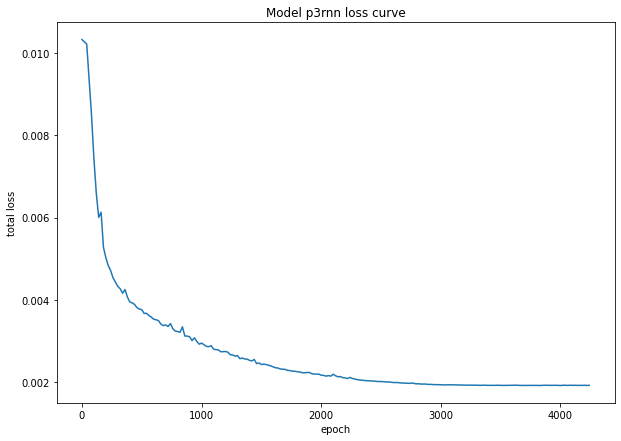

In [119]:
import json
tmet = json.load(open(f'{args.models_base}{args.model}/train_metrics.json'))

eps, loss = [], []
for m in tmet:
    eps.append(m.get('epoch'))
    loss.append(m.get('epoch_loss'))

plt.figure(figsize=(10, 7))
plt.plot(eps, loss);
plt.xlabel('epoch')
plt.ylabel('total loss');
plt.title(f'Model {args.model} loss curve');

### Concat several models loss curves

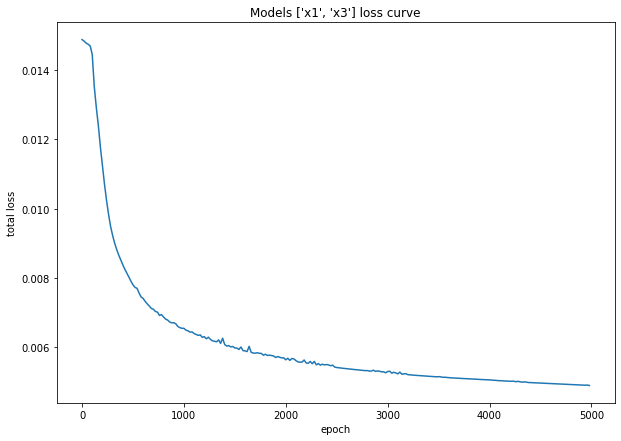

In [54]:
models_ids = ['x1', 'x3']
eps, loss = [], []
import json
for model_name in models_ids:
    tmet = json.load(open(f'{args.models_base}{model_name}/train_metrics.json'))
    for m in tmet:
        eps.append(m.get('epoch'))
        loss.append(m.get('epoch_loss'))
        
plt.figure(figsize=(10, 7))
plt.plot(eps, loss);
plt.xlabel('epoch')
plt.ylabel('total loss');
plt.title(f'Models {models_ids} loss curve');

### Visualization

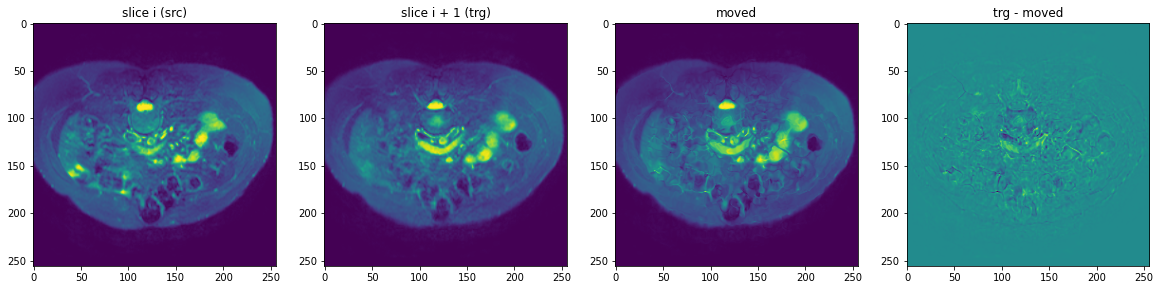

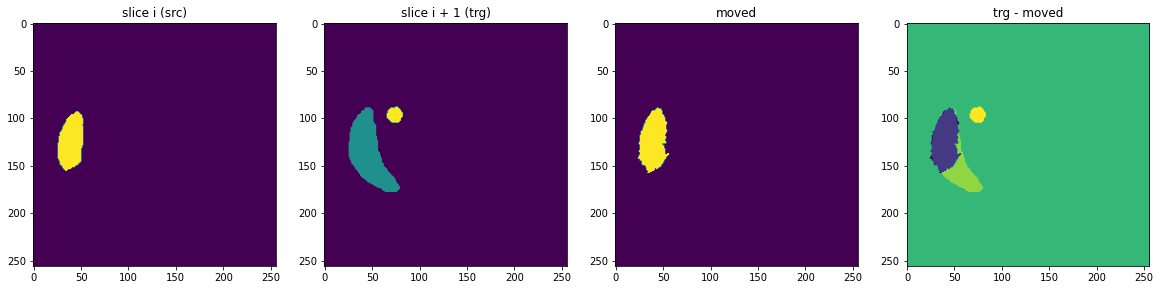

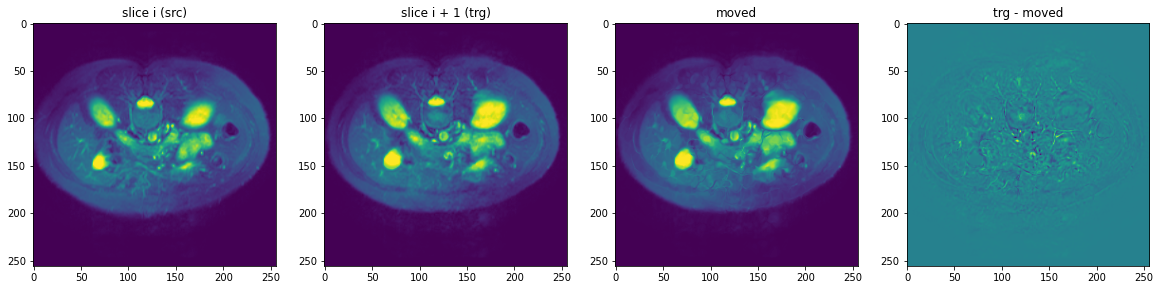

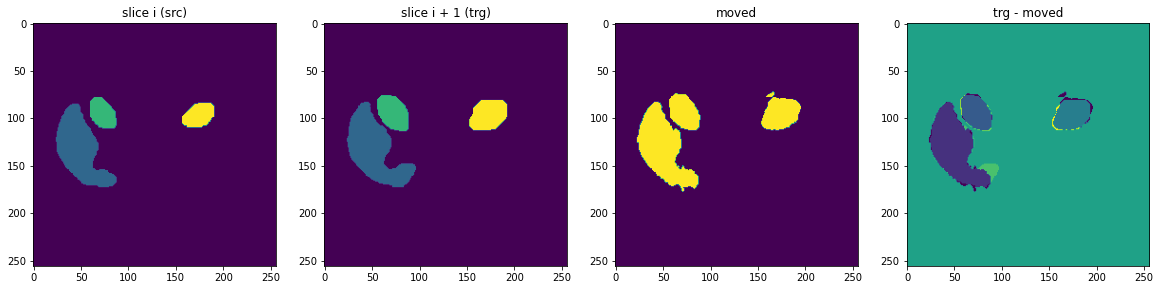

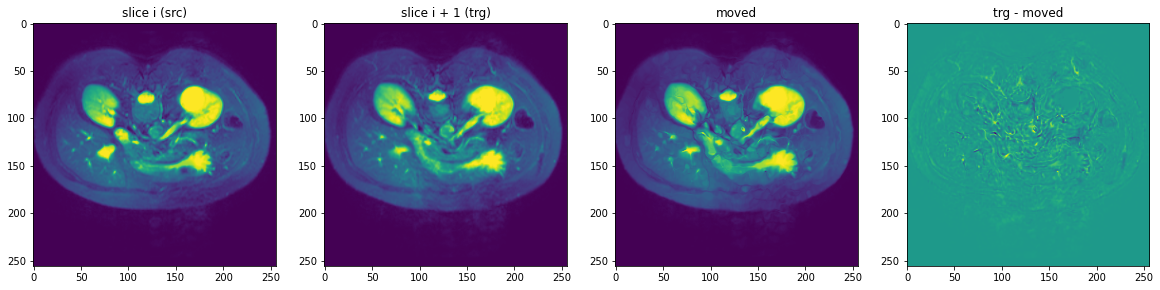

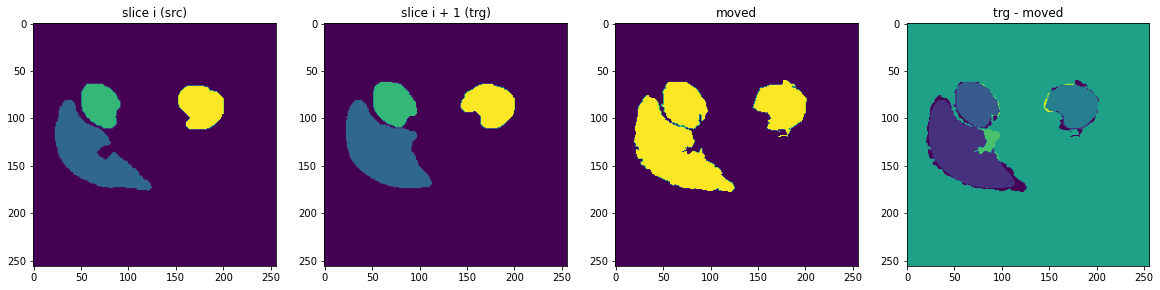

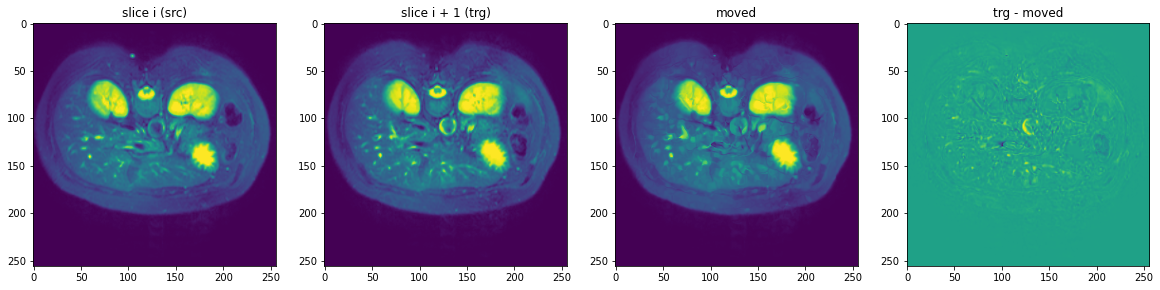

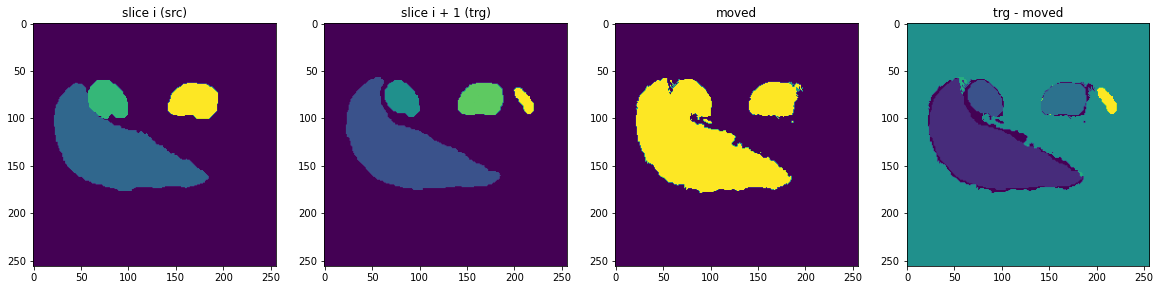

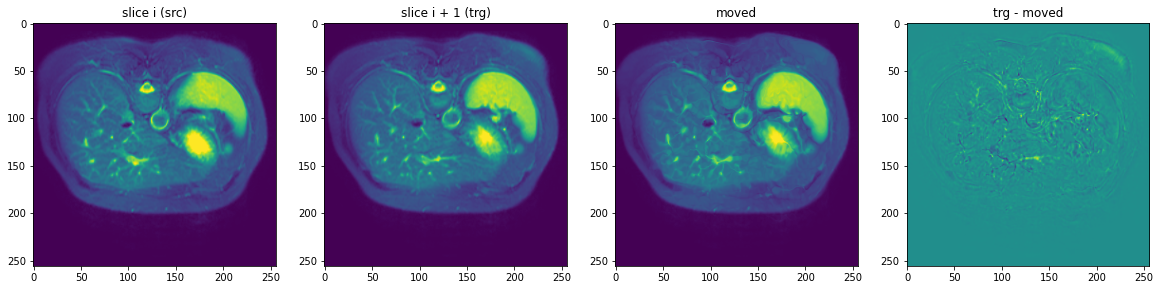

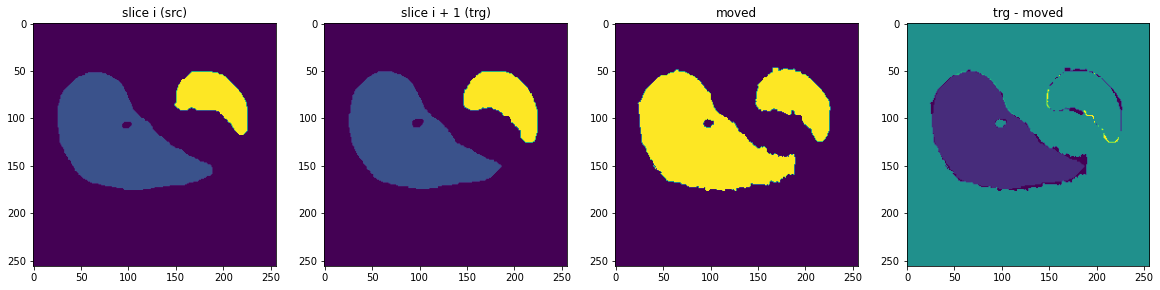

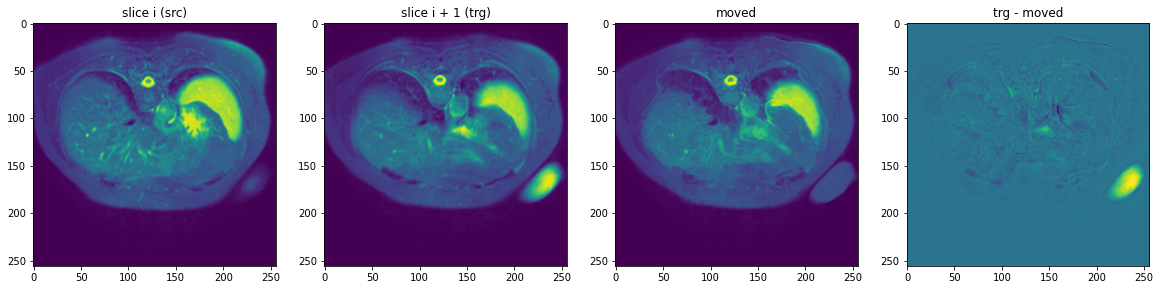

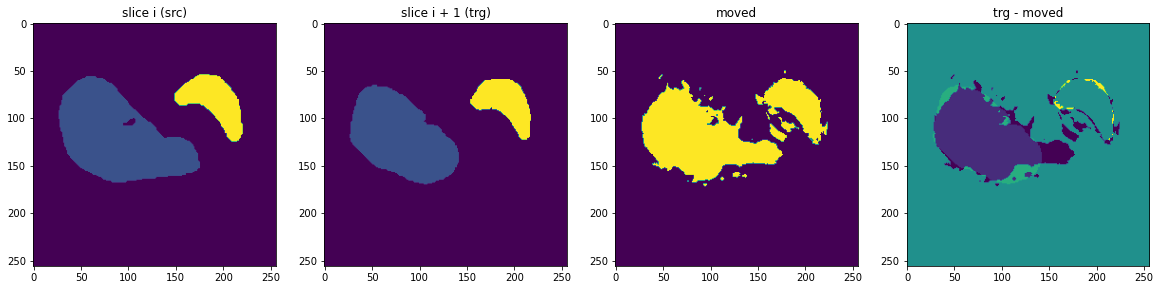

In [128]:
for d_idx, data in enumerate(dataloader):
    imgs, lbs = data
    bs, num_layers = imgs.shape[0], imgs.shape[1]
    imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    if args.multi_windows:
        data_ft = zip(np.arange(0, num_layers - window, window), np.arange(window, num_layers, window))
    else:
        data_ft = zip([0], [num_layers])
    with torch.no_grad():
        for f, t in data_ft:
            fmoved, fmoved_labels, bmoved, bmoved_labels = model(imgs[f:t], lbs[f:t], use_rnn=args.use_rnn)
            f_trgs, b_trgs = imgs[f:t][1:], imgs[f:t][:-1]
            f_lbs_trgs, b_lbs_trgs = lbs[f:t][1:], lbs[f:t][:-1]
            zero = torch.zeros_like(fmoved_labels).to('cuda')
            one = torch.ones_like(fmoved_labels).to('cuda')
            f_fixed_lbs = torch.where(f_lbs_trgs > 0, one, zero)
            f_moved_lbs = torch.where(fmoved_labels > 0, one, zero)
            fdice_score += dice(f_fixed_lbs.cpu(), f_moved_lbs.cpu())
            b_fixed_lbs = torch.where(b_lbs_trgs > 0, one, zero)
            b_moved_lbs = torch.where(bmoved_labels > 0, one, zero)
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 14)) 
            ax1.imshow(b_trgs[i][0][0].cpu())
            ax1.title.set_text('slice i (src)')
            ax2.imshow(f_trgs[i][0][0].cpu())
            ax2.title.set_text('slice i + 1 (trg)')
            ax3.imshow(fmoved[i][0][0].cpu())
            ax3.title.set_text('moved')
            ax4.imshow(f_trgs[i][0][0].cpu() - fmoved[i][0][0].cpu())
            ax4.title.set_text('trg - moved')

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 14)) 
            ax1.imshow(b_lbs_trgs[i][0][0].cpu())
            ax1.title.set_text('slice i (src)')
            ax2.imshow(f_lbs_trgs[i][0][0].cpu())
            ax2.title.set_text('slice i + 1 (trg)')
            ax3.imshow(f_moved_lbs[i][0][0].cpu())
            ax3.title.set_text('moved')
            ax4.imshow(f_lbs_trgs[i][0][0].cpu() - f_moved_lbs[i][0][0].cpu())
            ax4.title.set_text('trg - moved')

### Some Data Analysis

Checking the effect of difference in number of organs between source and target slices

In [150]:
def check_eq(a, b):
    if len(a) != len(b):
        return False
    for i, el in enumerate(a):
        if b[i] != el:
            return False
    return True
    


def dice(y_true, y_pred):
    eq_dices, neq_dices = [], []
    
    neq_list = []
    for i in range(y_true.shape[0] - 1):
        a, b = y_true[i], y_pred[i]
        
        zero = torch.zeros_like(a)
        one = torch.ones_like(a)
        c = torch.where(a > 0, one, zero)
        d = torch.where(b > 0, one, zero)
        top = 2 * np.multiply(c, d).sum()
        bottom = c.sum() + d.sum()
        
        if check_eq(np.unique(a), np.unique(b)):
            eq_dices.append((top / bottom).item())
        else:
            neq_list.append(i)
            neq_dices.append((top / bottom).item())
    return eq_dices, neq_dices, neq_list

In [162]:
all_eq, all_neq = [], []
neq_dict = {}
for i, pl in enumerate([labels[3]]):
    
    y_true = labels[i][1:]
    y_pred = labels[i][:-1]
    
    eq, neq, neq_list = dice(y_true, y_pred)
    all_eq += eq
    all_neq += neq
    neq_dict[i] = neq_list

In [163]:
for i, nel in neq_dict.items():
    print(f'{i}: {nel}')

0: [1, 5, 13, 17, 19]


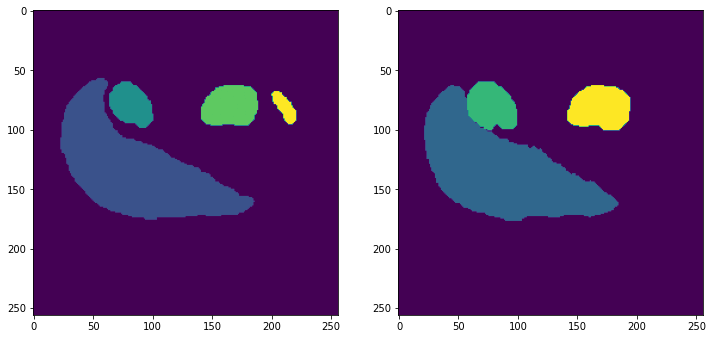

In [164]:
pid, s = 3, 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(labels[pid][1:][s])
ax2.imshow(labels[pid][:-1][s]);

In [165]:
import warnings
warnings.simplefilter("ignore")

same mean: 0.8723
diff mean: 0.8454


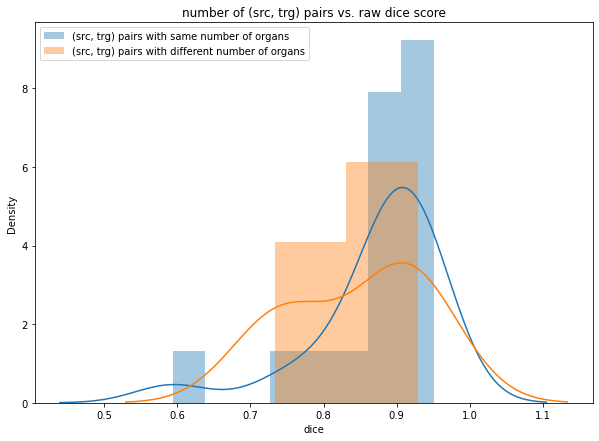

In [180]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame()
data['dice'] = all_eq + all_neq
data['same'] = [1 for _ in range(len(all_eq))] + [0 for _ in range(len(all_neq))]

plt.figure(figsize=(10, 7))
sns.distplot(data.dice[data.same==1], label="(src, trg) pairs with same number of organs");
sns.distplot(data.dice[data.same==0], label="(src, trg) pairs with different number of organs");
plt.title("number of (src, trg) pairs vs. raw dice score")
plt.legend()
print('same mean:', round(np.mean(all_eq), 4))
print('diff mean:', round(np.mean(all_neq), 4))

In [181]:
# for i, s in enumerate(f_trgs):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
#     ax1.imshow(s[0][0].cpu())
#     ax2.imshow(fmoved[i][0][0].cpu())